In [ ]:
# This tests algorithms to remove cosmic rays from multiepoch spectra (in particular from SDSS stripe 82
# spectra, which are too many for manual removal)

# Created 2021 May 10 by E.S.

In [19]:
import pandas as pd
import numpy as np
import glob
import sys
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

%matplotlib inline

In [2]:
stem = "/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/"
file_list = glob.glob(stem + "*")

In [3]:
# find all parent names (i.e., one name for each target, whether or not multiepoch observations were made)

parent_list = list(set([i.split("g00")[0] for i in file_list]))

In [4]:
file_1 = "spec-2618-54506-0488g001.dat_000"
file_2 = "spec-2618-54506-0488g002.dat_000"

df1 = pd.read_csv(stem + file_1, names=["wavel","flux","cont"], delim_whitespace = True)
df2 = pd.read_csv(stem + file_2, names=["wavel","flux","cont"], delim_whitespace = True)

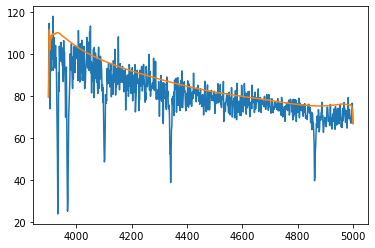

In [5]:
plt.plot(df1["wavel"], df1["flux"])
plt.plot(df1["wavel"], df1["cont"])
plt.show()

In [ ]:
# initialize list to hold single-epoch spectra names
## TBD

In [6]:
def plot_result(spec0, spec1):
    
    # remove from consideration the regions around the absorption lines, which change with time and can 
    # be misidentified as a cosmic ray hit (a spectrum with an actual hit will have to be discarded manually)
    spec0_flux_copy = spec0["flux"].to_numpy()
    spec1_flux_copy = spec1["flux"].to_numpy()
    half_width = 20
    cond_1 = np.logical_and(spec0["wavel"] > 3933.66-half_width, spec0["wavel"] < 3933.66+half_width)
    cond_2 = np.logical_and(spec0["wavel"] > 3970.075-half_width, spec0["wavel"] < 3970.075+half_width)
    cond_3 = np.logical_and(spec0["wavel"] > 4101.71-half_width, spec0["wavel"] < 4101.71+half_width)
    cond_4 = np.logical_and(spec0["wavel"] > 4340.472-half_width, spec0["wavel"] < 4340.472+half_width)
    cond_5 = np.logical_and(spec0["wavel"] > 4861.29-half_width, spec0["wavel"] < 4861.29+half_width)
    spec0_flux_copy[cond_1] = np.nan
    spec0_flux_copy[cond_2] = np.nan
    spec0_flux_copy[cond_3] = np.nan
    spec0_flux_copy[cond_4] = np.nan
    spec0_flux_copy[cond_5] = np.nan
    spec1_flux_copy[cond_1] = np.nan
    spec1_flux_copy[cond_2] = np.nan
    spec1_flux_copy[cond_3] = np.nan
    spec1_flux_copy[cond_4] = np.nan
    spec1_flux_copy[cond_5] = np.nan
    
    resids = np.subtract(spec0_flux_copy,spec1_flux_copy)
    
    # sigma clip
    # (note sigma lower is a large number, to keep track of which spectrum has the (+) cosmic ray)
    filtered_data = sigma_clip(resids, sigma_lower=50, sigma_upper=5, iters=1)
    
    # also remove points adjacent to those masked, by rolling spectra by two elements in each direction,
    # subtracting them and finding where difference is nan
    diff_roll_p1 = np.subtract(filtered_data,np.roll(filtered_data,1))
    diff_roll_p2 = np.subtract(filtered_data,np.roll(filtered_data,2))
    diff_roll_n1 = np.subtract(filtered_data,np.roll(filtered_data,-1))
    diff_roll_n2 = np.subtract(filtered_data,np.roll(filtered_data,-2))
    mark_bad_array = np.subtract(np.subtract(diff_roll_p1,diff_roll_p2),np.subtract(diff_roll_n1,diff_roll_n2))
    mask_bad_pre_line_restore = np.ma.getmask(mark_bad_array)
    
    masked_flux_0 = np.ma.masked_array(spec0["flux"], mask=mask_bad)
    masked_wavel_0 = np.ma.masked_array(spec0["wavel"], mask=mask_bad)
    masked_flux_1 = np.ma.masked_array(spec1["flux"], mask=mask_bad)
    masked_wavel_1 = np.ma.masked_array(spec1["wavel"], mask=mask_bad)

    num_removed = np.subtract(len(resids), np.isfinite(filtered_data).sum())
    
    plt.clf()
    fig = plt.figure(figsize=(24,9))
    plt.plot(df_single_0["wavel"],resids,color="red")
    #plt.plot(df_single_0["wavel"],df_single_0["flux"])
    plt.plot(df_single_0["wavel"],spec0_flux_copy)
    #plt.plot(df_single_1["wavel"],df_single_1["flux"])
    plt.plot(masked_wavel_0,masked_flux_0,color="k")
    #plt.title("pts removed: " + str(num_removed))
    #plt.show()
    string_rand = str(np.random.randint(low=0,high=10000))
    plt.savefig("junk_"+string_rand+".png")
    
    return

<Figure size 432x288 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

<Figure size 1728x648 with 0 Axes>

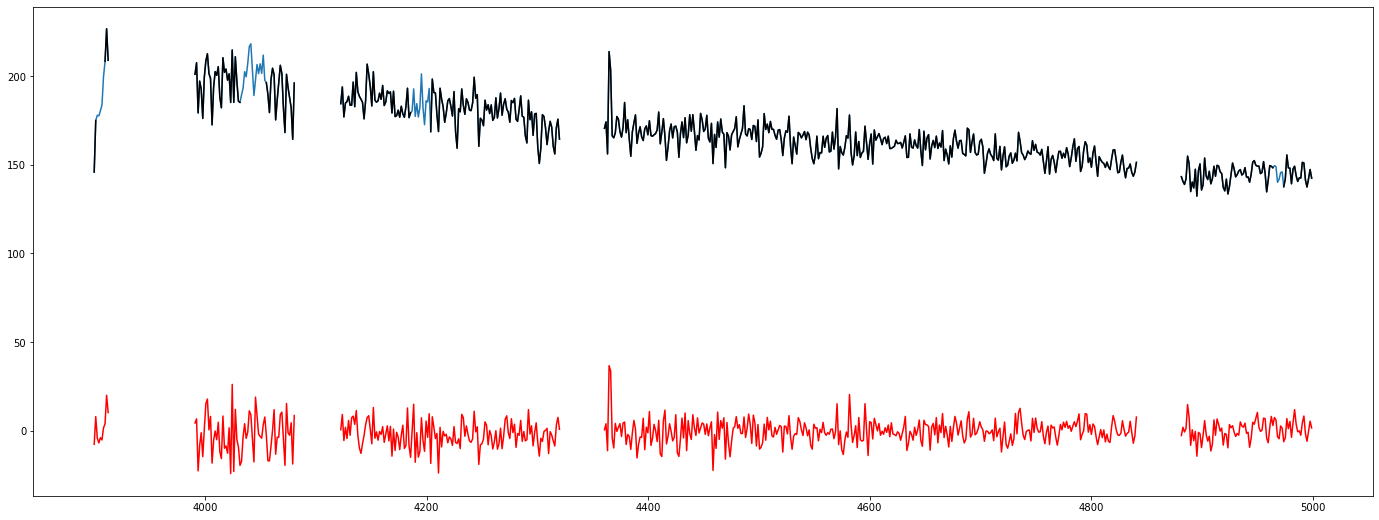

In [53]:
# find the file names of spectra corresponding to each parent; if there is only 1, ignore; 
# if >= 2, do median comparison to flag it for cosmic rays

for t in range(0,60):#len(parent_list)):
    
    #print("----------")
    #print(t)
    matching = list(filter(lambda x: parent_list[t] in x, file_list))
    
    if (len(matching) == 1):
        
        continue
    
    elif (len(matching) == 2):
        
        df_single_0 = pd.read_csv(matching[0], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_1 = pd.read_csv(matching[1], names=["wavel","flux","noise"], delim_whitespace=True)
        
        plot_result(df_single_0, df_single_1)
        
        
    elif (len(matching) == 3):
        
        df_single_0 = pd.read_csv(matching[0], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_1 = pd.read_csv(matching[1], names=["wavel","flux","noise"], delim_whitespace=True)
        df_single_2 = pd.read_csv(matching[2], names=["wavel","flux","noise"], delim_whitespace=True)
        
    elif (len(matching) > 3):
        
        continue

In [ ]:
## NEW METHOD

In [4]:
# find names of spectra for which continuum has been calculated

stem_s82_norm = "/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/"
# find individual file names
file_list = glob.glob(stem_s82_norm + "*")
# find all parent names (i.e., one name for each target, whether or not multiepoch observations were made)
parent_list = list(set([i.split("g00")[0] for i in file_list]))

In [57]:
def mean_spec(df_1_pass,df_2_pass):
    '''
    Average two spectra and flag points based on their deviation from the average spectrum
    
    INPUTS:
    df_1_pass: dataframe including wavelength and flux
    df_2_pass: "  "
    '''
    
    # sanity check that we are not averaging flux at different wavelengths
    if ((len(df_1_pass) == len(df_2_pass)) and 
        (df_1_pass["wavel"].iloc[0] == df_2_pass["wavel"].iloc[0]) and 
        (df_1_pass["wavel"].iloc[-1] == df_2_pass["wavel"].iloc[-1])):
    
        print("Looks like sane comparison")
    
    else:
        
        print("Apples and oranges!")
        return
    
    df_concat = pd.concat((df1["flux"], df2["flux"]),axis=1)
    df_concat["avg_cols"] = df_concat.mean(axis=1).values 
    
    avg_spec = df_1_pass.copy(deep=True)
    avg_spec["flux"] = df_concat["avg_cols"]
    avg_spec = avg_spec.drop(columns="noise")
    
    return avg_spec

In [61]:
def flag_from_avg(df_empir_pass,df_avg_pass,sigma_choice=1):
    '''
    Average two spectra and flag points based on their deviation from the average spectrum
    
    INPUTS:
    df_empir_pass: dataframe of empirical spectrum
    df_avg_pass: dataframe of average spectrum
    sigma_choice: threshold for clipping
    '''
    
    # initialize
    masked_spec = df_empir_pass.copy(deep=True)
    masked_spec["flux_masked1"] = masked_spec["flux"]
    
    # take difference (note this preserves sign information)
    masked_spec["diff"] = np.subtract(df_empir_pass["flux"],df_avg_pass["flux"])
    
    # mask deviant points
    masked_spec["flux_masked1"] = masked_spec["flux_masked1"].mask(
                                                                    masked_spec["diff"] > sigma_choice*np.nanstd(masked_spec["diff"]), 
                                                                    inplace=True
                                                                    )
    
    return masked_spec

In [58]:
avg_spec_A = mean_spec(df_single_0,df_single_1)

Looks like sane comparison


In [62]:
test = flag_from_avg(df_single_0,avg_spec_A,sigma_choice=1)

In [63]:
test

wavel   flux     noise flux_masked1    diff
0    3900.0  61.85  61.85000         None -18.295
1    3901.4  68.65  66.79679         None -33.385
2    3902.8  68.55  70.61259         None -21.905
3    3904.2  73.07  72.40039         None -23.040
4    3905.6  78.36  74.58567         None  -5.240
..      ...    ...       ...          ...     ...
781  4993.4  59.69  60.78291         None  -6.795
782  4994.8  59.00  60.95886         None  -9.605
783  4996.2  58.66  60.55286         None -13.120
784  4997.6  60.51  61.40366         None -10.530
785  4999.0  61.78  61.78000         None  -5.605

[786 rows x 5 columns]

In [33]:
len(parent_list)

2347

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2365-53739-0530g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2181-53524-0188g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1687-53260-0518g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1687-53260-0518g001.dat_000']


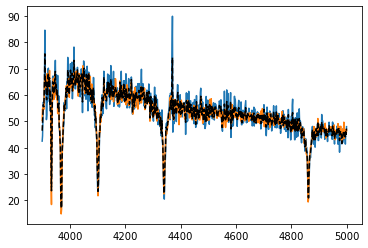

-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2804-54368-0215g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2804-54368-0215g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2804-54368-0215g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2804-54368-0215g001.dat_000']


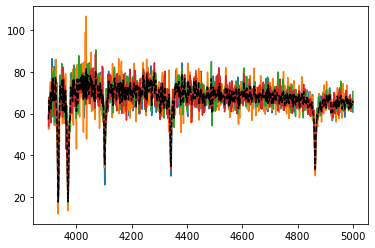

-------------------------
5 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3127-54835-0532g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3127-54835-0532g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3127-54835-0532g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3127-54835-0532g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3127-54835-0532g004.dat_000']


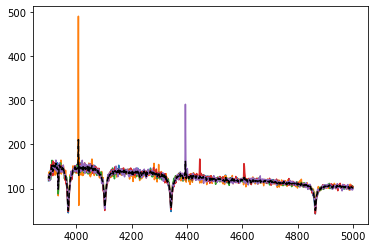

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1288-52731-0071g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2119-53792-0520g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1742-53053-0202g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0595-52023-0362g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2612-54480-0487g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/real

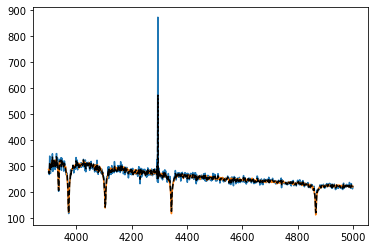

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0569-52264-0296g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0569-52264-0296g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0569-52264-0296g001.dat_000']


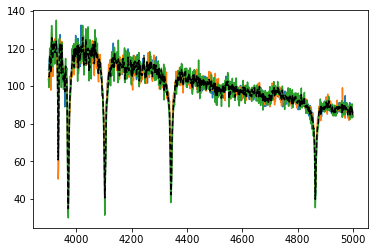

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0972-52435-0403g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2552-54632-0247g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2791-54556-0071g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2368-53758-0063g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2368-53758-0063g002.dat_000']


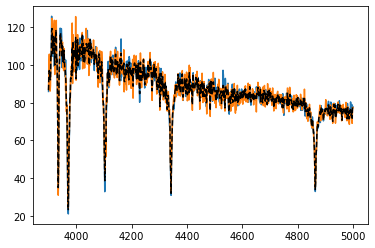

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1236-52751-0453g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2042-53378-0373g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2042-53378-0373g002.dat_000']


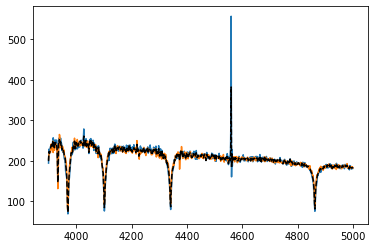

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0595-52023-0566g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3427-54979-0335g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3427-54979-0335g002.dat_000']


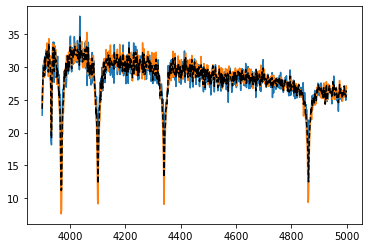

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2368-53758-0005g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2368-53758-0005g001.dat_000']


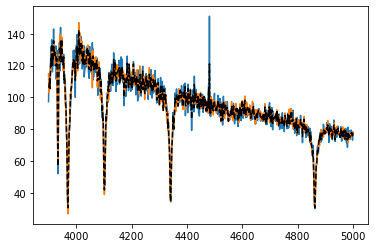

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0913-52433-0027g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0913-52433-0027g002.dat_000']


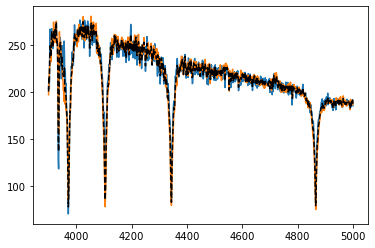

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0886-52381-0424g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0886-52381-0424g002.dat_000']


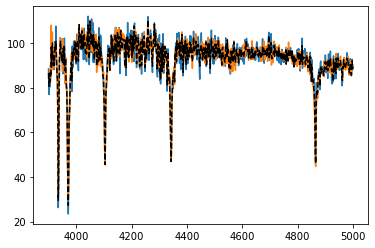

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2506-54179-0257g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1171-52753-0248g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2902-54629-0304g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2902-54629-0304g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2902-54629-0304g003.dat_000']


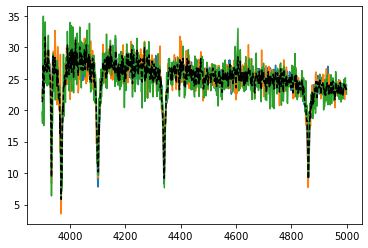

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1798-53851-0114g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1798-53851-0114g001.dat_000']


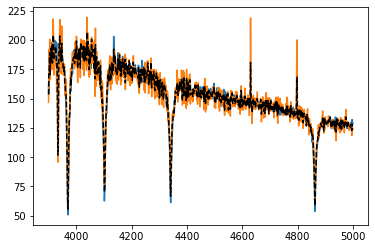

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0335-52000-0307g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2969-54586-0185g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1576-53496-0577g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1576-53496-0577g002.dat_000']


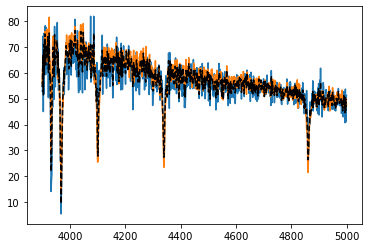

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2606-54154-0421g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2606-54154-0421g002.dat_000']


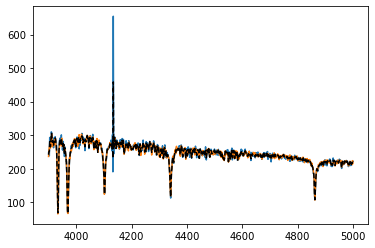

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1993-53762-0161g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1993-53762-0161g002.dat_000']


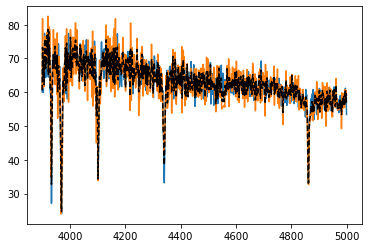

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2410-54087-0612g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2410-54087-0612g002.dat_000']


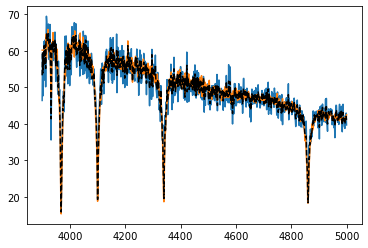

-------------------------
6 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2305-54414-0180g006.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2305-54414-0180g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2305-54414-0180g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2305-54414-0180g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2305-54414-0180g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2305-54414-0180g003.dat_000']


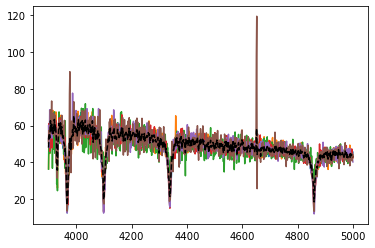

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2314-53712-0229g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2314-53712-0229g002.dat_000']


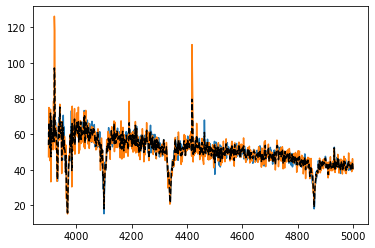

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1852-53534-0068g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1852-53534-0068g001.dat_000']


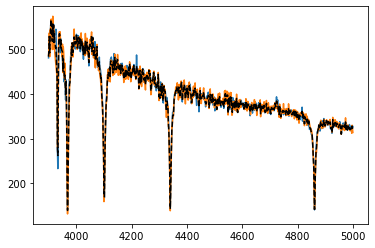

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0505-52317-0207g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2892-54552-0350g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2892-54552-0350g002.dat_000']


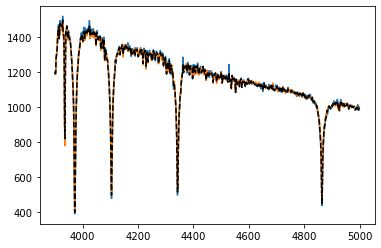

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1289-52734-0232g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3128-54776-0055g010.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0644-52173-0440g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2374-53765-0249g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2374-53765-0249g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2374-53765-0249g001.dat

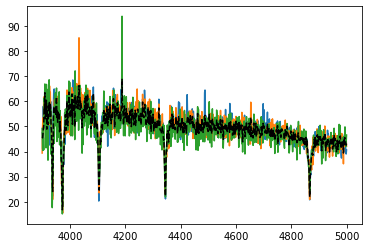

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1722-53852-0319g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0973-52426-0619g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0973-52426-0619g001.dat_000']


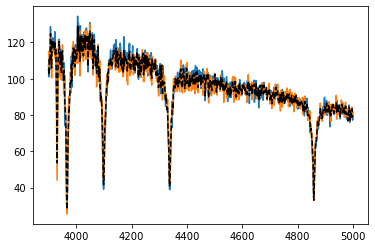

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2175-54612-0356g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2175-54612-0356g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2175-54612-0356g003.dat_000']


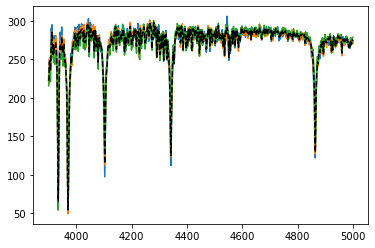

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2124-53770-0241g001.dat_000']
-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3404-54967-0487g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3404-54967-0487g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3404-54967-0487g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3404-54967-0487g004.dat_000']


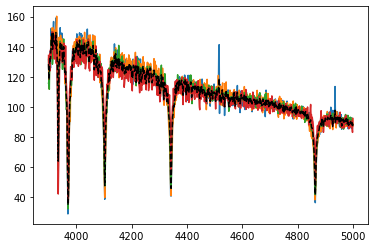

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2037-53446-0080g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3263-54887-0089g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3263-54887-0089g002.dat_000']


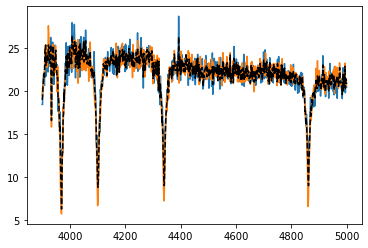

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0505-52317-0629g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0982-52466-0098g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0982-52466-0098g001.dat_000']


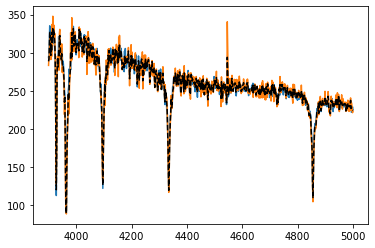

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0980-52431-0098g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0980-52431-0098g001.dat_000']


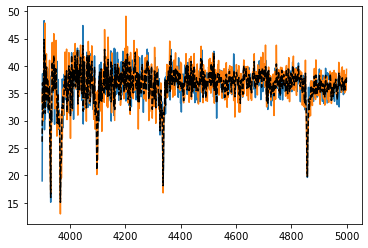

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2783-54524-0640g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0395-51783-0008g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0395-51783-0008g001.dat_000']


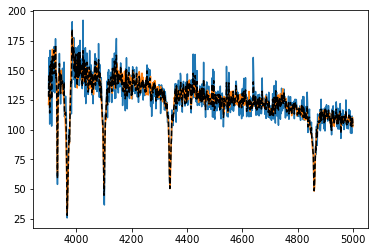

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1521-52945-0209g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1521-52945-0209g001.dat_000']


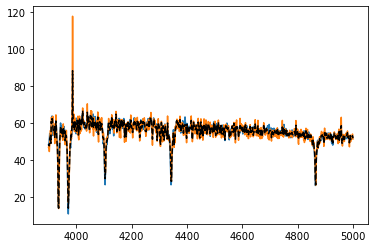

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3466-54998-0574g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1679-53149-0413g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0972-52435-0346g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0852-52375-0251g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1974-53430-0633g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/real

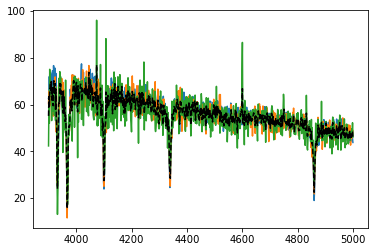

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2137-54206-0052g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3234-54885-0038g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2968-54585-0621g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1338-52765-0397g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0427-51900-0437g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.r

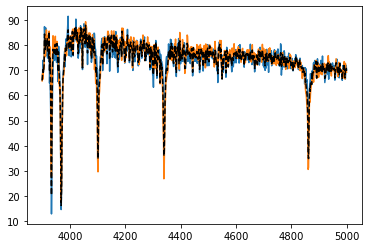

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2939-54515-0503g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2939-54515-0503g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2939-54515-0503g003.dat_000']


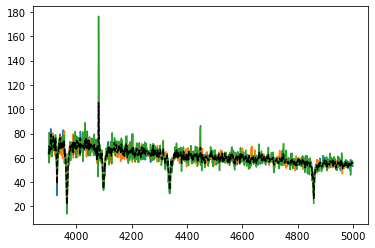

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1770-53171-0392g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1942-53415-0068g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1942-53415-0068g001.dat_000']


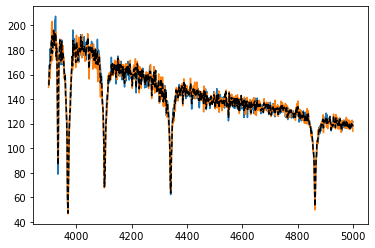

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3299-54908-0570g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3299-54908-0570g001.dat_000']


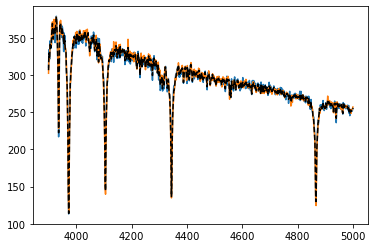

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2028-53818-0382g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0342-51691-0406g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0342-51691-0406g002.dat_000']


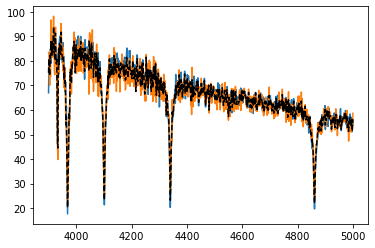

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3188-54831-0350g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0944-52614-0484g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0944-52614-0484g001.dat_000']


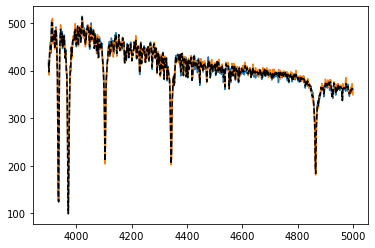

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2282-53683-0631g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2282-53683-0631g002.dat_000']


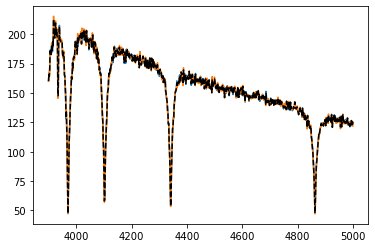

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0813-52354-0606g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0813-52354-0606g001.dat_000']


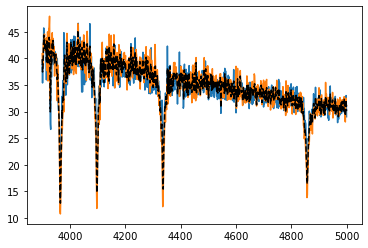

-------------------------
7 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0542-51993-0510g006.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0542-51993-0510g007.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0542-51993-0510g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0542-51993-0510g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0542-51993-0510g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0542-51993-0510g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0542-51993-0510g003.dat_000']


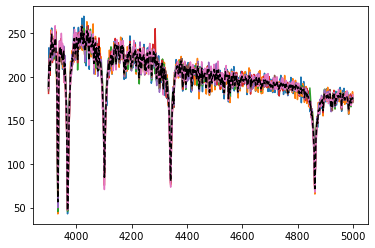

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1798-53851-0509g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1798-53851-0509g001.dat_000']


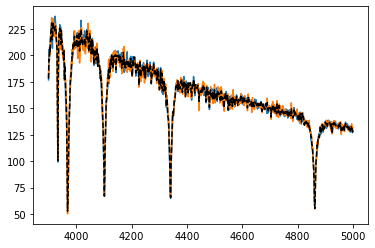

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2799-54368-0608g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2799-54368-0608g002.dat_000']


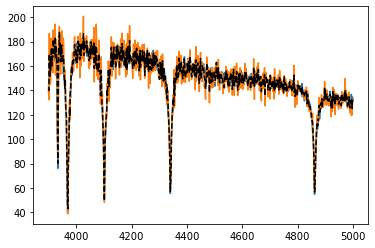

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1265-52705-0579g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0914-52721-0323g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0914-52721-0323g002.dat_000']


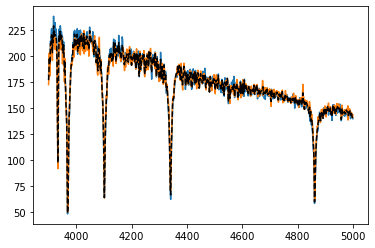

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1210-52701-0068g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1210-52701-0068g002.dat_000']


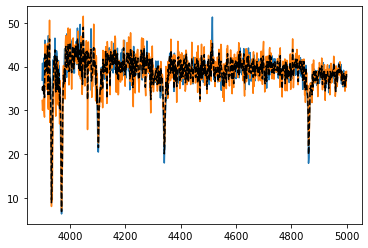

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2895-54567-0600g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1900-53262-0306g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1567-53172-0034g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2609-54476-0178g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2609-54476-0178g001.dat_000']


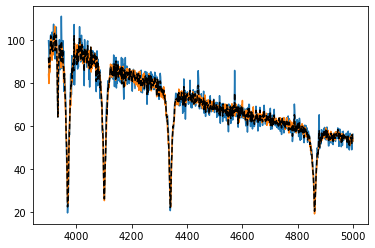

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2173-53874-0237g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2611-54477-0538g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1452-53112-0554g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1452-53112-0554g002.dat_000']


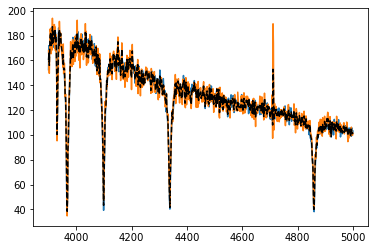

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0565-52225-0048g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0565-52225-0048g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0565-52225-0048g003.dat_000']


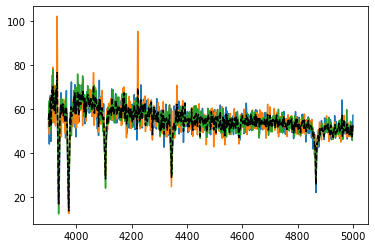

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2644-54210-0445g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2644-54210-0445g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2644-54210-0445g001.dat_000']


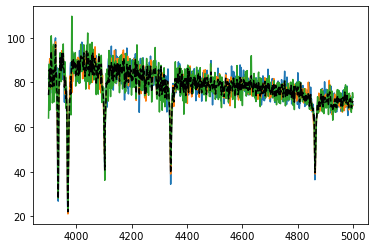

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1229-52723-0170g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1229-52723-0170g001.dat_000']


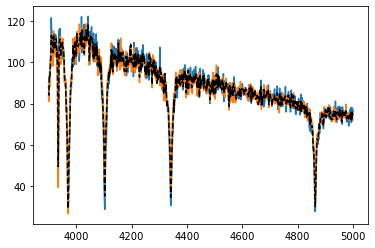

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1910-53321-0270g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1910-53321-0270g002.dat_000']


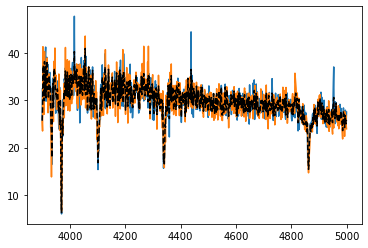

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1727-53859-0184g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1727-53859-0184g001.dat_000']


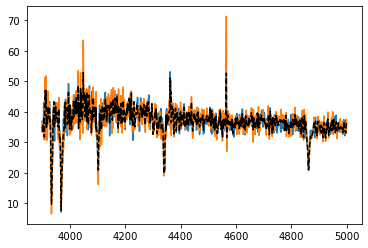

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3223-54865-0573g001.dat_000']
-------------------------
5 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3129-54747-0200g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3129-54747-0200g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3129-54747-0200g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3129-54747-0200g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3129-54747-0200g004.dat_000']


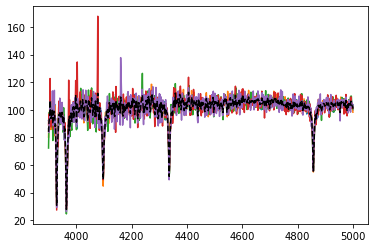

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2890-54495-0306g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2890-54495-0306g002.dat_000']


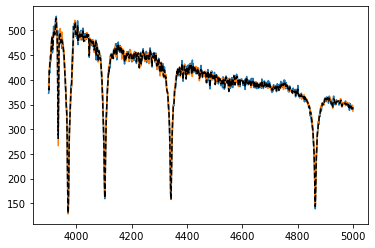

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2597-54231-0484g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1386-53116-0007g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1386-53116-0007g002.dat_000']


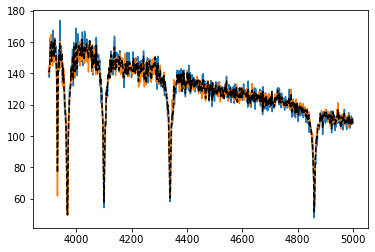

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1999-53503-0056g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3390-54945-0572g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3390-54945-0572g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3390-54945-0572g001.dat_000']


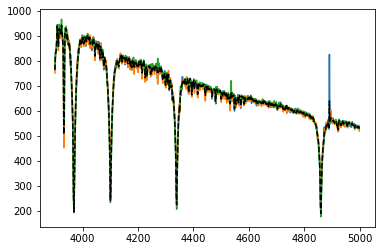

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1594-52992-0263g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1594-52992-0263g001.dat_000']


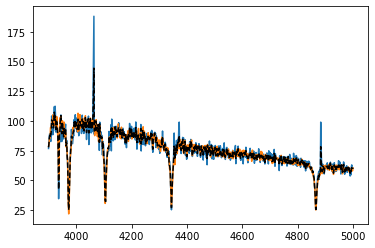

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0996-52641-0477g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0996-52641-0477g001.dat_000']


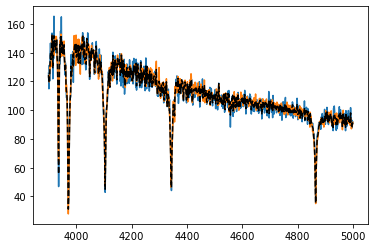

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0277-51908-0416g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0277-51908-0416g001.dat_000']


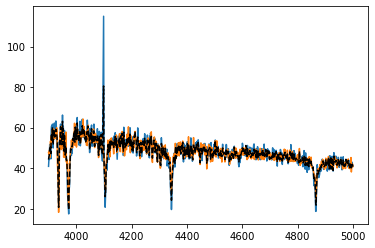

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0507-52353-0591g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2062-53381-0614g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2268-53682-0631g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2268-53682-0631g001.dat_000']


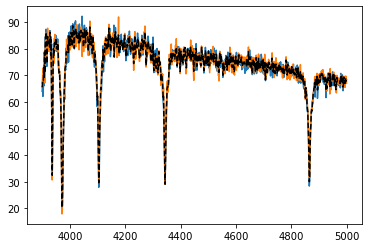

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2278-53711-0182g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2278-53711-0182g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2278-53711-0182g003.dat_000']


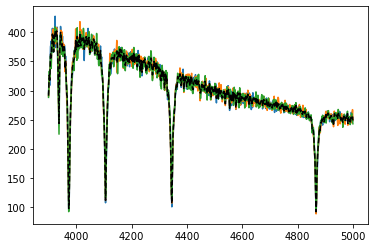

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2041-53387-0441g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2041-53387-0441g002.dat_000']


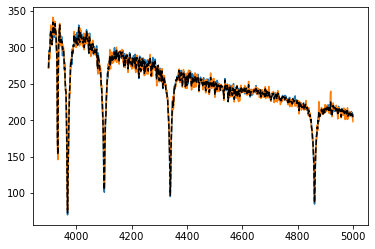

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2227-53820-0050g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0331-52368-0060g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3287-54941-0089g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3287-54941-0089g002.dat_000']


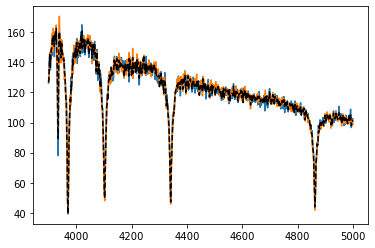

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0523-52026-0574g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0523-52026-0574g001.dat_000']


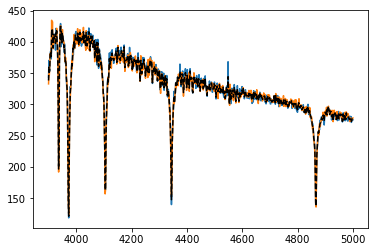

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2647-54495-0246g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0348-51671-0094g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2815-54414-0066g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2815-54414-0066g002.dat_000']


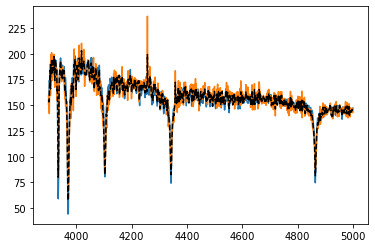

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0569-52264-0531g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0569-52264-0531g001.dat_000']


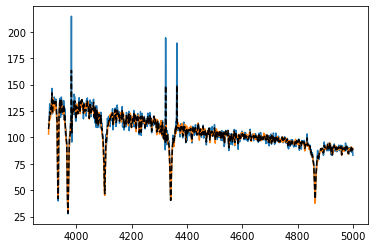

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1898-53260-0182g001.dat_000']
-------------------------
6 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2872-54533-0337g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2872-54533-0337g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2872-54533-0337g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2872-54533-0337g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2872-54533-0337g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_ou

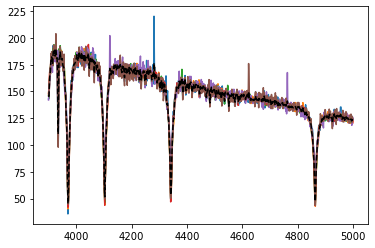

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2182-53905-0263g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0485-51909-0138g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0485-51909-0138g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0485-51909-0138g001.dat_000']


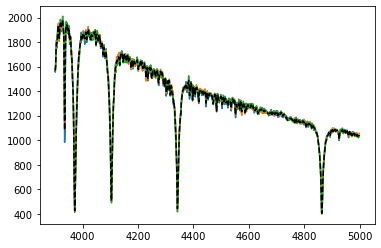

-------------------------
8 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3141-55008-0459g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3141-55008-0459g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3141-55008-0459g008.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3141-55008-0459g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3141-55008-0459g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3141-55008-0459g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3141-55008-0459g006.dat_000', '/Us

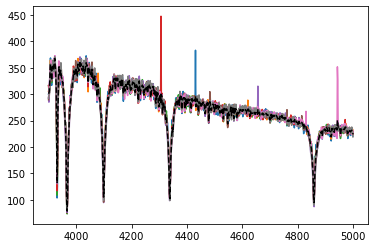

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2158-54209-0623g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1959-53440-0517g001.dat_000']
-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3480-54999-0629g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3480-54999-0629g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3480-54999-0629g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3480-54999-0629g001.dat_000']


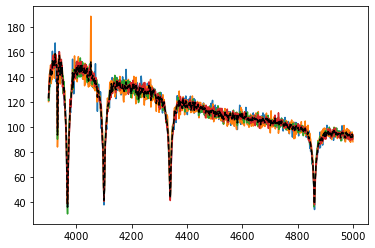

-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2808-54524-0275g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2808-54524-0275g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2808-54524-0275g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2808-54524-0275g004.dat_000']


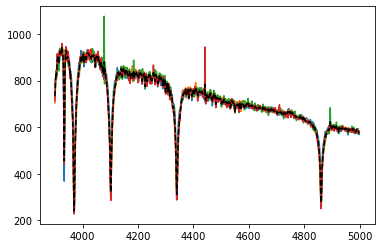

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1739-53050-0082g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1739-53050-0082g002.dat_000']


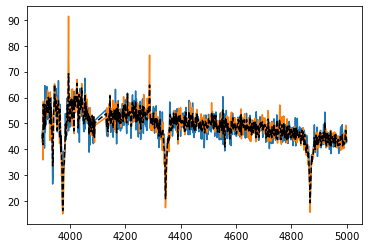

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3233-54891-0081g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3233-54891-0081g002.dat_000']


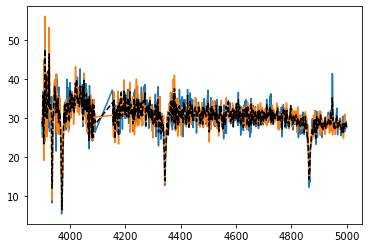

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2950-54559-0420g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0828-52317-0040g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0828-52317-0040g001.dat_000']


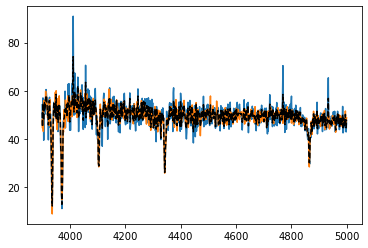

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1191-52674-0139g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1956-53437-0002g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1173-52790-0455g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3234-54885-0169g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3234-54885-0169g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3234-54885-0169g001.dat

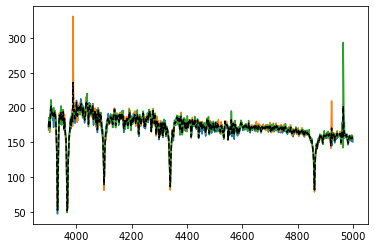

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0373-51788-0368g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0336-51999-0241g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2973-54591-0565g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3222-54862-0326g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3222-54862-0326g002.dat_000']


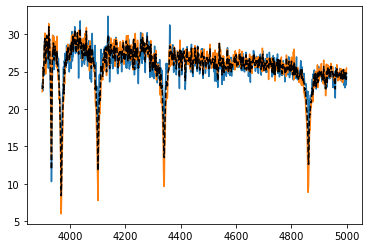

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0521-52326-0521g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0521-52326-0521g001.dat_000']


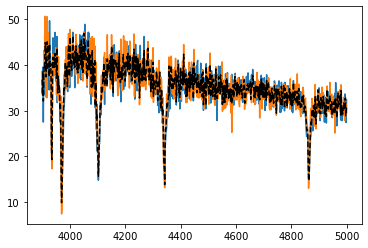

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1310-53033-0060g001.dat_000']
-------------------------
9 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3131-54731-0108g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3131-54731-0108g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3131-54731-0108g006.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3131-54731-0108g007.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3131-54731-0108g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_ou

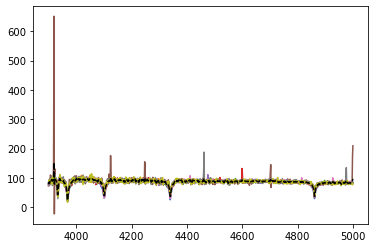

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2457-54180-0056g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1613-53115-0169g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1613-53115-0169g002.dat_000']


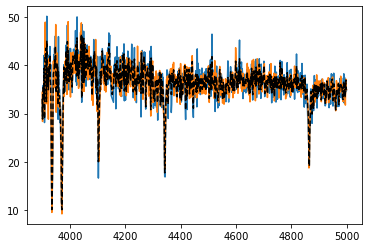

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2854-54480-0254g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2854-54480-0254g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2854-54480-0254g001.dat_000']


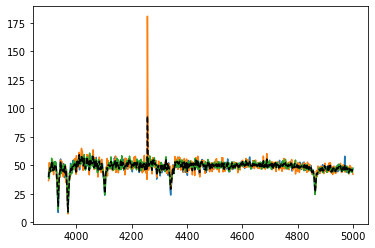

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1939-53389-0493g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1933-53381-0162g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1933-53381-0162g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1933-53381-0162g002.dat_000']


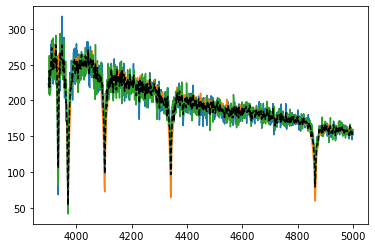

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0334-51993-0433g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1727-53859-0514g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2781-54266-0467g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2781-54266-0467g001.dat_000']


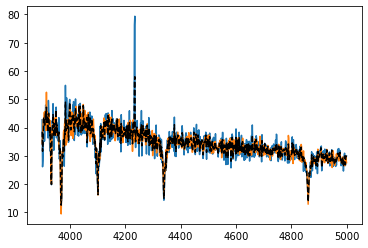

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2552-54632-0217g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2552-54632-0217g002.dat_000']


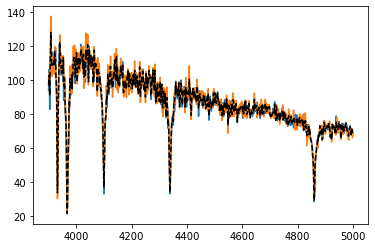

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0285-51930-0532g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0285-51930-0327g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0348-51671-0341g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0348-51671-0341g002.dat_000']


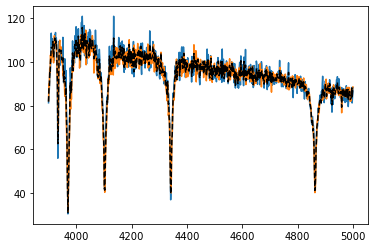

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0917-52400-0047g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0917-52400-0047g002.dat_000']


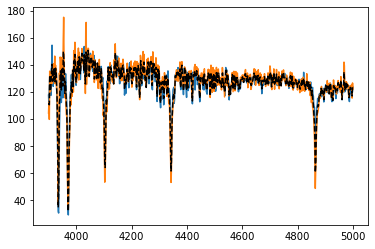

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2558-54140-0526g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3128-54776-0055g012.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2210-53535-0201g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0480-51989-0313g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0480-51989-0313g002.dat_000']


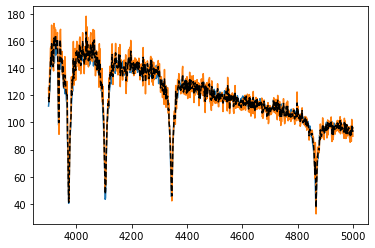

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2000-53495-0344g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2000-53495-0344g001.dat_000']


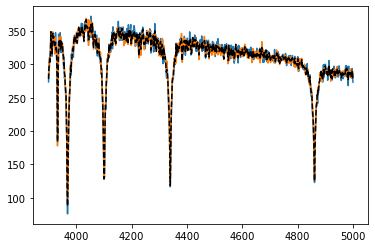

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0367-51997-0454g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0367-51997-0454g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0367-51997-0454g001.dat_000']


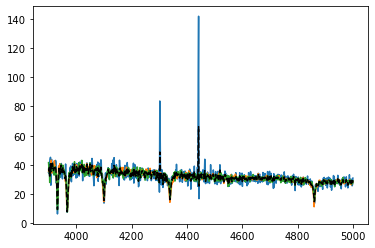

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0757-52238-0264g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0757-52238-0264g001.dat_000']


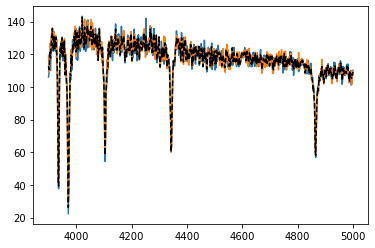

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0853-52374-0454g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3308-54919-0130g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3308-54919-0130g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3308-54919-0130g003.dat_000']


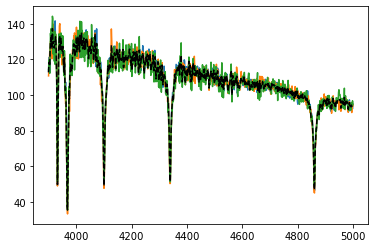

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0984-52442-0259g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0984-52442-0259g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0984-52442-0259g001.dat_000']


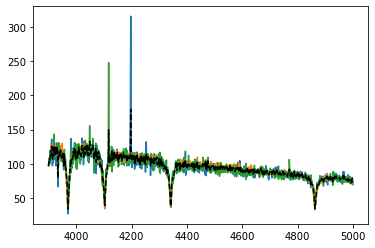

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0852-52375-0551g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3176-54832-0369g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3176-54832-0369g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3176-54832-0369g002.dat_000']


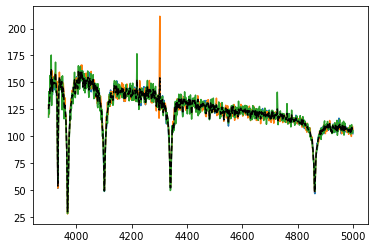

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1802-53885-0614g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0916-52378-0070g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1052-52466-0427g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0858-52316-0133g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2805-54380-0176g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/

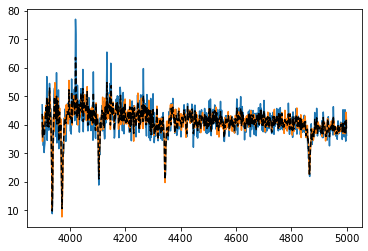

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1568-53169-0165g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1568-53169-0165g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1568-53169-0165g003.dat_000']


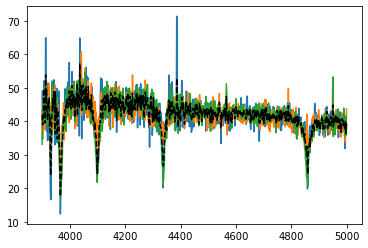

-------------------------
8 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2904-54574-0392g006.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2904-54574-0392g007.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2904-54574-0392g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2904-54574-0392g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2904-54574-0392g008.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2904-54574-0392g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2904-54574-0392g002.dat_000', '/Us

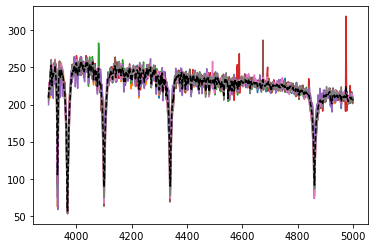

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0604-52079-0382g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0604-52079-0382g002.dat_000']


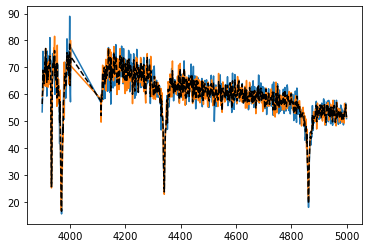

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1918-53240-0121g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1918-53240-0121g001.dat_000']


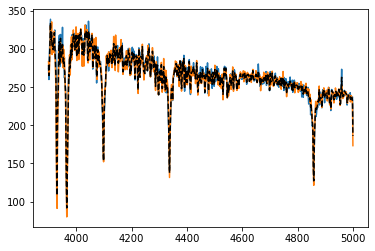

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0292-51609-0220g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0292-51609-0220g001.dat_000']


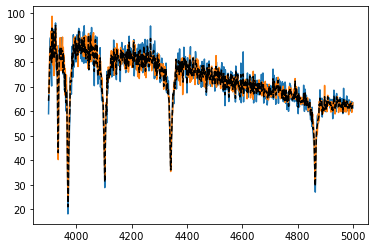

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1723-53905-0423g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0332-52367-0170g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0449-51900-0103g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0449-51900-0103g001.dat_000']


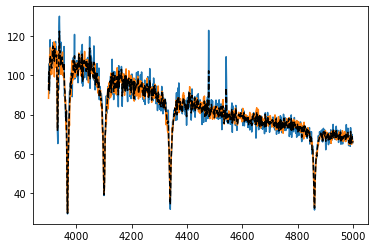

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1602-53117-0326g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2040-53384-0023g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2040-53384-0023g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2040-53384-0023g001.dat_000']


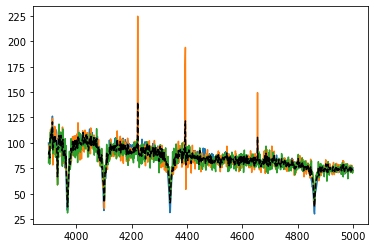

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3327-54951-0393g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3327-54951-0393g002.dat_000']


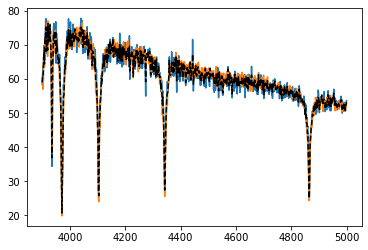

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2083-53359-0565g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2083-53359-0565g002.dat_000']


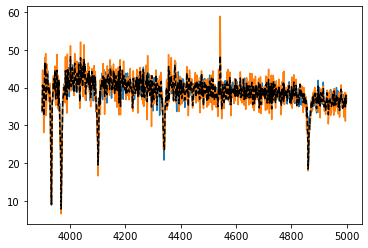

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2265-53674-0035g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0282-51658-0208g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0282-51658-0208g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0282-51658-0208g001.dat_000']


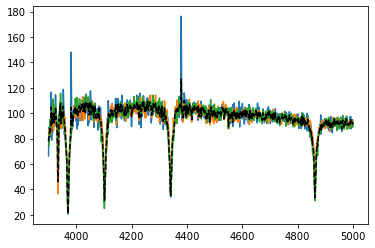

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1973-53432-0417g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1790-53876-0479g001.dat_000']
-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3253-54941-0270g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3253-54941-0270g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3253-54941-0270g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3253-54941-0270g004.dat_000']


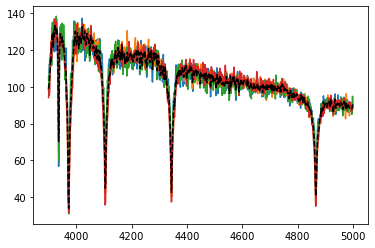

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2243-53794-0613g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2243-53794-0613g002.dat_000']


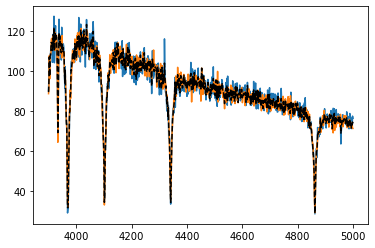

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2689-54149-0351g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2689-54149-0351g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2689-54149-0351g002.dat_000']


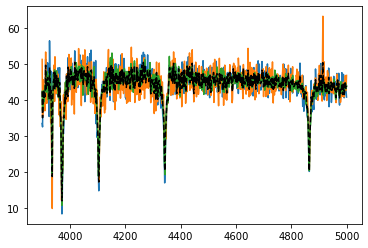

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2252-53565-0036g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1044-52468-0506g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2970-54589-0369g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2004-53737-0004g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1711-53535-0562g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/real

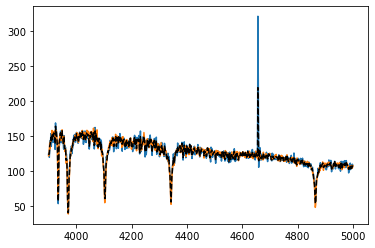

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2515-54180-0337g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2515-54180-0337g002.dat_000']


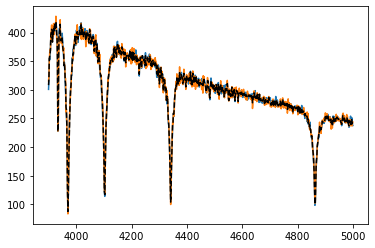

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2895-54567-0287g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2895-54567-0287g001.dat_000']


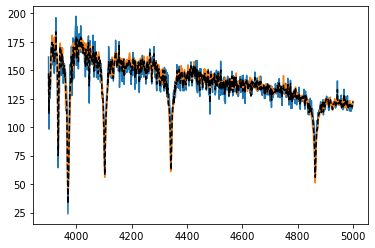

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2570-54081-0390g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2487-53852-0268g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2487-53852-0268g001.dat_000']


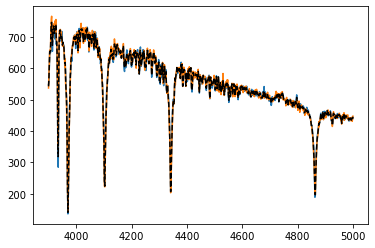

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2023-53851-0324g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1817-53851-0433g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1510-52992-0618g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1510-52992-0618g001.dat_000']


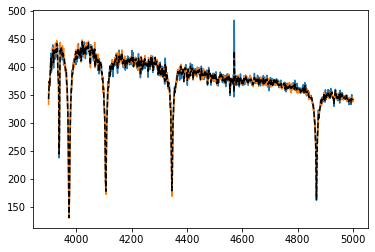

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0653-52145-0154g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0653-52145-0154g002.dat_000']


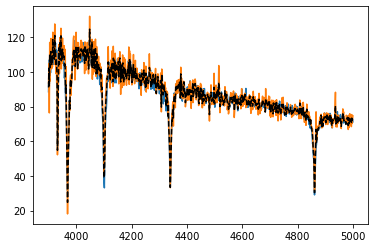

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0756-52577-0551g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0567-52252-0550g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0567-52252-0550g002.dat_000']


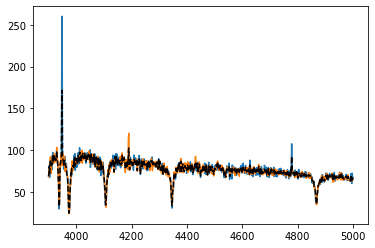

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2908-54611-0009g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2908-54611-0009g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2908-54611-0009g003.dat_000']


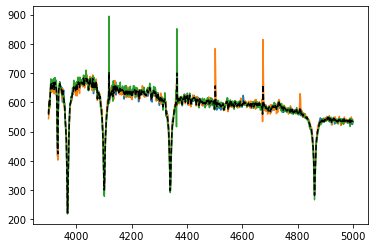

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1992-53466-0187g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0699-52202-0062g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0699-52202-0062g001.dat_000']


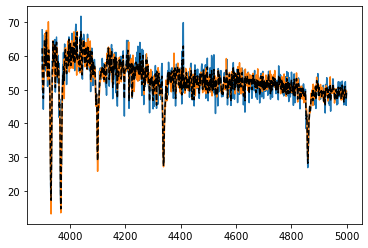

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1169-52753-0114g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1169-52753-0114g002.dat_000']


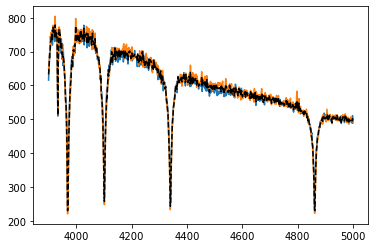

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0492-51955-0501g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0492-51955-0501g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0492-51955-0501g001.dat_000']


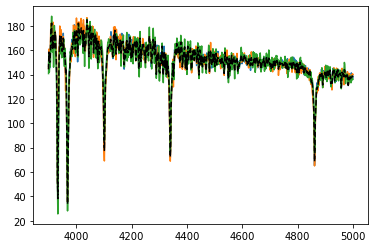

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2004-53737-0373g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0980-52431-0228g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2815-54414-0062g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2815-54414-0062g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2815-54414-0062g003.dat_000']


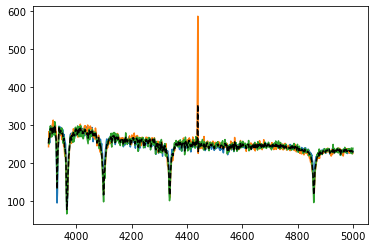

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2022-53827-0093g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1335-52824-0495g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2234-53823-0604g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2234-53823-0604g002.dat_000']


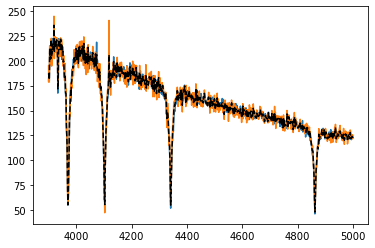

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3311-54943-0071g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3246-54939-0361g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1353-53083-0019g001.dat_000']
-------------------------
6 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3144-54763-0221g006.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3144-54763-0221g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3144-54763-0221g004.dat

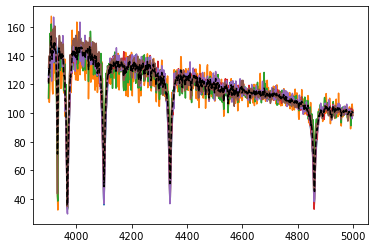

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0913-52433-0626g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0913-52433-0626g001.dat_000']


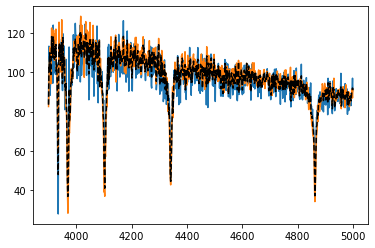

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2294-54524-0457g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1914-53729-0427g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1740-53050-0586g001.dat_000']
-------------------------
6 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2328-53728-0223g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2328-53728-0223g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2328-53728-0223g006.dat

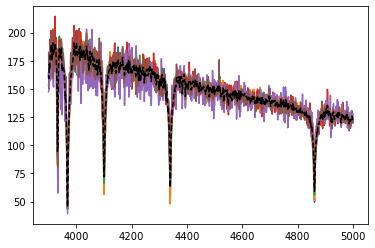

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1981-53463-0246g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3213-54865-0120g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3179-54830-0570g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3179-54830-0570g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3179-54830-0570g003.dat_000']


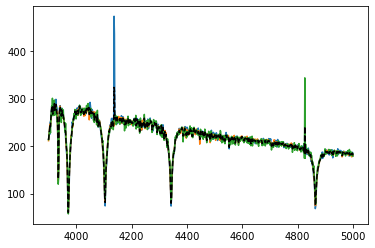

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1693-53446-0258g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1693-53446-0258g002.dat_000']


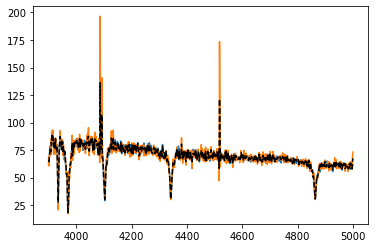

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2798-54397-0396g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1000-52643-0059g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3478-55008-0470g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1486-52993-0369g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3181-54860-0588g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/real

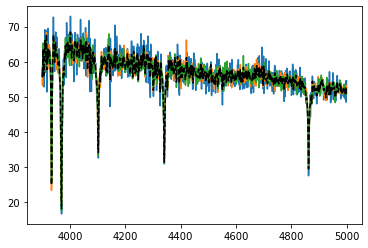

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1335-52824-0567g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1335-52824-0567g002.dat_000']


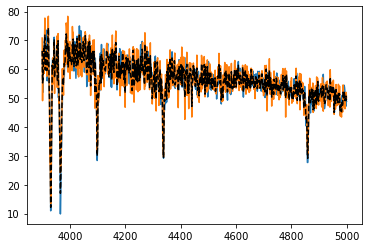

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2621-54380-0525g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1918-53240-0268g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0856-52339-0525g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2880-54509-0289g001.dat_000']
-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1729-53858-0295g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/real

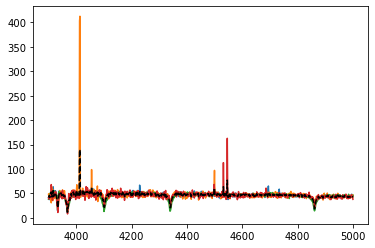

-------------------------
4 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2657-54502-0558g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2657-54502-0558g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2657-54502-0558g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2657-54502-0558g003.dat_000']


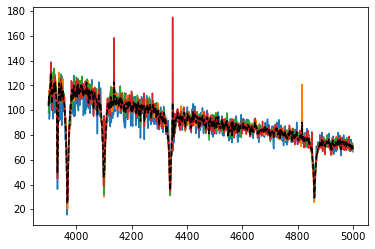

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3214-54866-0389g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3214-54866-0389g002.dat_000']


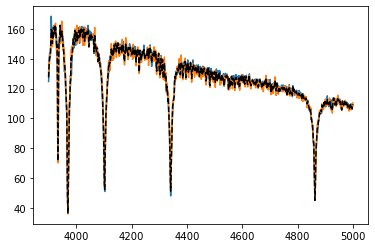

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1570-53149-0183g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1961-53299-0443g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1280-52738-0036g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1280-52738-0036g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1280-52738-0036g003.dat_000']


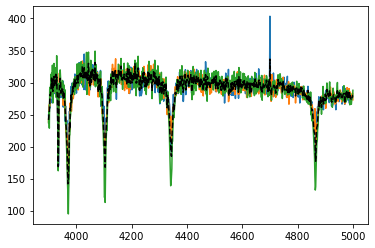

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0574-52355-0075g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0851-52376-0602g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1320-52759-0290g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1320-52759-0290g002.dat_000']


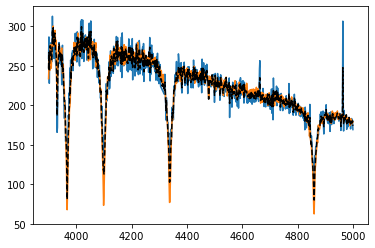

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1842-53501-0348g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1694-53472-0285g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1475-52903-0385g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2457-54180-0118g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2457-54180-0118g001.dat_000']


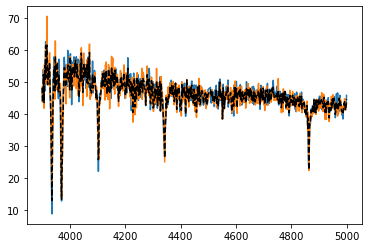

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1506-53003-0076g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1506-53003-0076g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1506-53003-0076g002.dat_000']


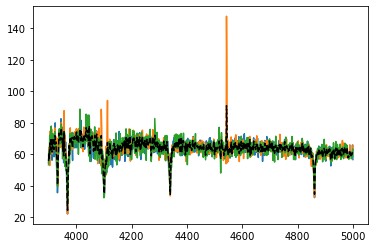

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3373-54940-0612g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3373-54940-0612g002.dat_000']


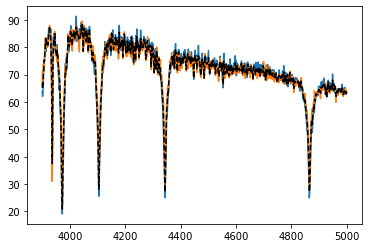

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2909-54653-0478g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2909-54653-0478g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2909-54653-0478g001.dat_000']


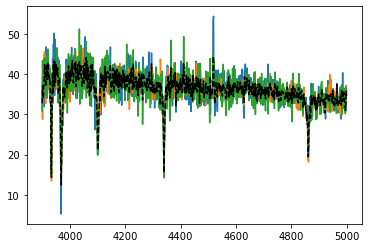

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0741-52261-0274g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0457-51901-0612g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1953-53358-0640g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1953-53358-0640g002.dat_000']


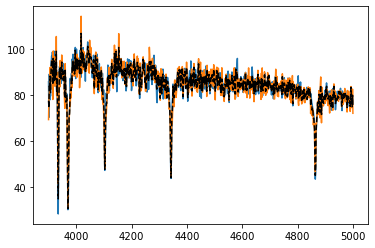

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2521-54538-0014g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0618-52049-0428g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0618-52049-0428g002.dat_000']


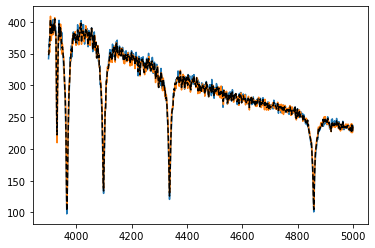

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2066-53349-0436g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0699-52202-0621g001.dat_000']
-------------------------
5 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3184-54850-0257g005.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3184-54850-0257g004.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3184-54850-0257g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3184-54850-0257g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyra

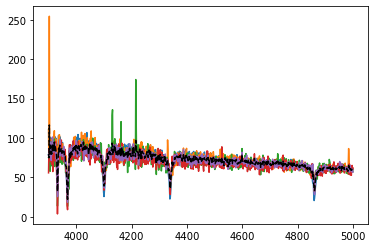

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2284-53708-0498g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1186-52646-0138g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1186-52646-0138g002.dat_000']


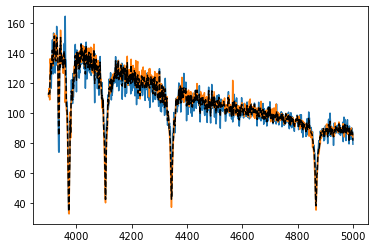

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1007-52706-0112g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1007-52706-0112g002.dat_000']


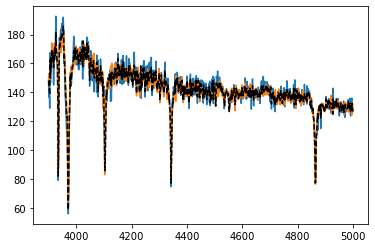

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2897-54585-0551g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2384-53763-0155g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1585-52962-0500g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1759-53081-0463g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0538-52029-0572g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.r

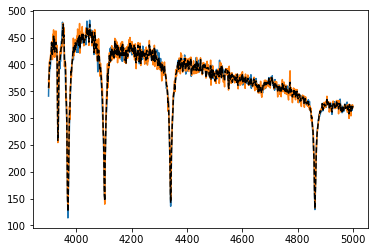

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3252-54893-0150g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0537-52027-0425g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0812-52352-0289g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0812-52352-0289g001.dat_000']


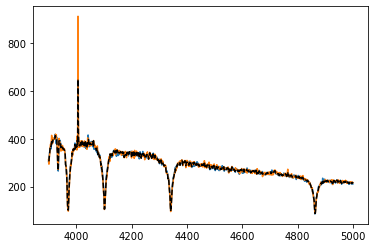

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1358-52994-0568g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1358-52994-0568g001.dat_000']


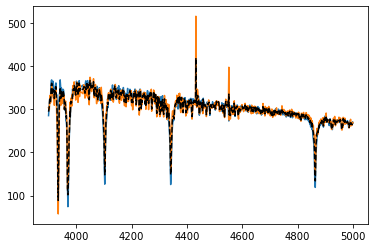

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3291-54939-0329g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3291-54939-0329g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-3291-54939-0329g003.dat_000']


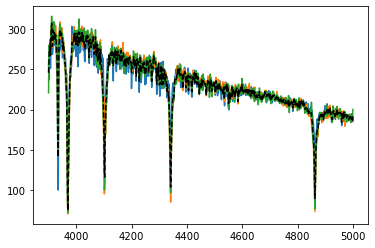

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2848-54453-0079g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2848-54453-0079g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2848-54453-0079g002.dat_000']


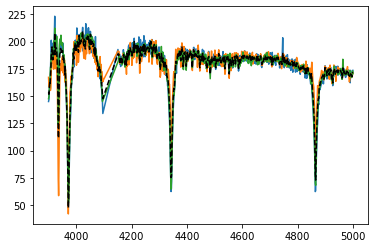

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1308-53053-0579g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1106-52912-0155g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2276-53712-0161g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0784-52327-0012g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0784-52327-0012g001.dat_000']


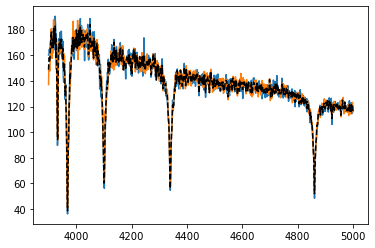

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0999-52636-0545g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2609-54476-0050g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2609-54476-0050g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2609-54476-0050g001.dat_000']


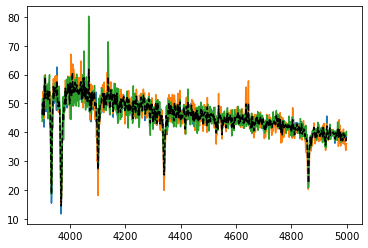

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1918-53240-0231g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1918-53240-0231g001.dat_000']


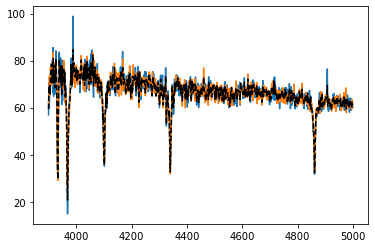

-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0287-52023-0594g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0287-52023-0594g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0287-52023-0594g003.dat_000']


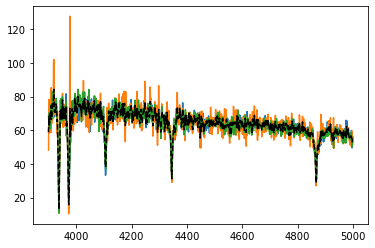

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1188-52650-0010g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2558-54140-0200g001.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2558-54140-0200g002.dat_000']


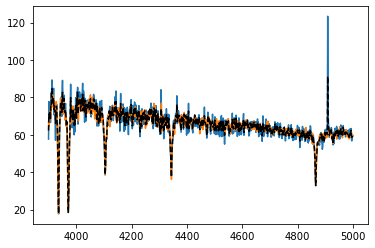

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2023-53851-0357g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2793-54271-0464g001.dat_000']
-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1569-53168-0457g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1569-53168-0457g001.dat_000']


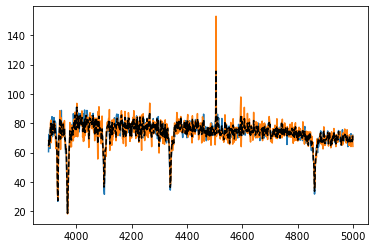

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2623-54328-0089g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2110-53467-0129g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2266-53679-0150g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2266-53679-0150g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2266-53679-0150g001.dat_000']


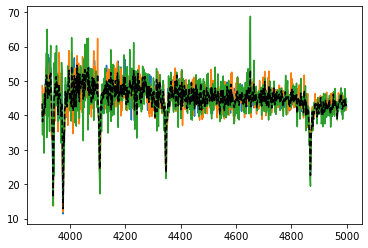

-------------------------
2 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2216-53795-0058g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2216-53795-0058g001.dat_000']


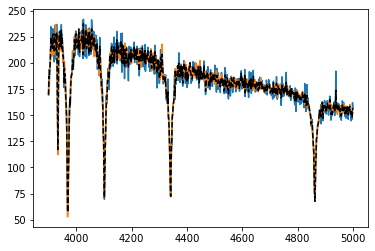

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-2657-54502-0149g001.dat_000']
-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-1906-53293-0499g001.dat_000']
-------------------------
3 matches found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0830-52293-0384g003.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0830-52293-0384g002.dat_000', '/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0830-52293-0384g001.dat_000']


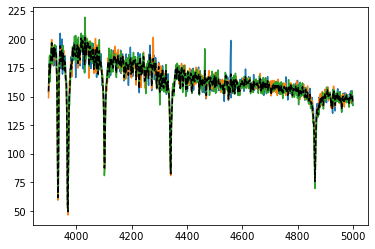

-------------------------
Only one match found:
['/Users/bandari/Documents/git.repos/rrlyrae_metallicity/rrlyrae_metallicity/realizations_output/norm/spec-0495-51988-0510g001.dat_000']


<Figure size 432x288 with 0 Axes>

In [34]:
# Steps for removing cosmic rays from spectra with >1 for a given object

# Step 1:
# Average two normalized spectra (following the normalization of the raw spectra)
# Flag (#1) points that are N sigma off from the average [use cenfunc=“median”]; keep track of direction

# Step 2:
# Go back to the spectra BEFORE ANY NORMALIZATION and averaging, and remove (mask) the flagged points
# Normalize them anew
# Sigma-clip again, but use larger sigmas than in Step 1, and flag those points with another flag (#2)
# Remove (mask) those points from the spectra

# Step 3:
# Normalize one last time


# find the file names of spectra corresponding to each parent; if there is only 1, ignore; 
# if >= 2, do median comparison to flag it for cosmic rays

for t in range(0,300):#len(parent_list)):
    
    matching = list(filter(lambda x: parent_list[t] in x, file_list))
    
    print("-------------------------")
    
    if (len(matching) == 1):
        
        print("Only one match found:")
        print(matching)
    
    elif (len(matching) >= 2):
        
        print(str(len(matching)) + " matches found:")
        print(matching)
        
        # dictionary to hold dataframes
        d = {}
        
        # intialize array to contain all fluxes
        aggregate_flux_array = np.nan*np.ones((len(df_single_p),len(matching)))
        
        # collect spectra in single dictionary
        for p in range(0,len(matching)):
            
            df_single_p = pd.read_csv(matching[p], names=["wavel","flux","noise"], delim_whitespace=True)
            
            plt.plot(df_single_p["wavel"],df_single_p["flux"])
            
            # sanity check that wavelength abcissa are the same
            if p==0:
                # for checking wavel abcissa is same
                wavel_initial = df_single_p["wavel"].values
            else:
                if len(np.setdiff1d(df_single_p["wavel"].values,wavel_initial) >= 1):
                    print("Hey, the wavelength abcissas are not the same!")
                    sys.exit()

            # put fluxes into array
            aggregate_flux_array[:,p] = df_single_p["flux"].values
            
        # take mean
        mean_flux_array = np.mean(aggregate_flux_array,axis=1)

        plt.plot(wavel_initial,mean_flux_array,linestyle="--",color="k")
        plt.show()
        plt.clf()